In [1]:
BATCH_SIZE = 32
INPUT_SHAPE = (25, 16, 1)
DATASET_PATH = "output_frames"
DATASET_ZIP = "dataset.zip"

## Foundation

Include required libraries and tools under this section and adjust settings.

**TODO:**
- [ ] Explore the usage of garbage collections.

In [2]:
# Import required libraries.
import  tensorflow as tf

from    keras.models import Sequential
from    keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from    keras.utils import to_categorical

# Helper libraries.
import  numpy as np
from    sklearn.model_selection import train_test_split
from    sklearn.preprocessing import LabelEncoder
import  librosa

# Libraries for plotting.
import  matplotlib.pyplot as plt

# Other
import sys
import os
import zipfile

2025-03-12 14:16:43.046925: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 14:16:43.105912: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 14:16:43.183343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741785403.275377  144940 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741785403.296897  144940 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741785403.372718  144940 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Test for GPU and determine what GPU we have.
# Modified by student to remove warningen caused on local machine.
IN_COLAB = 'google.colab' in sys.modules

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU detected.")

No GPU detected.


E0000 00:00:1741785407.524080  144940 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1741785407.524977  144940 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [5]:
# Install Keras Tuner via PIP (if in colab).
if IN_COLAB:
    os.system('pip install keras_tuner')

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.7


## Import Dataset

If you're using Google Colab, the dataset has to be imported from Google Drive (or uploaded as a ZIP-file). This required giving permission to Google Colab! Otherwise, it will check if the dataset folder exists, if not, terminates the execution.

**TODO:**
- [ ] Add support for uploaded dataset.zip files.

In [6]:
# Function to load a ZIP file from Google Drive.
def load_zip_file(zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract to a specific directory
            zip_ref.extractall(DATASET_PATH)
            print(f"ZIP file '{zip_path}' loaded successfully.")
    except FileNotFoundError:
        print(f"Error: ZIP file not found at '{zip_path}'.")
    except zipfile.BadZipFile:
        print(f"Error: Invalid ZIP file at '{zip_path}'.")

# If in Colab, load the ZIP file from Google Drive.
if IN_COLAB:
    print("Loading and extracting dataset ZIP-file form Drive.")
    if (not os.path.exists(DATASET_PATH)):
        load_zip_file("drive/MyDrive/Studies/KTH/Courses/II143X/Model Creation/Data/output_frames.zip")
        
# Otherwise, check of files exist.
else:
    print("No Colab detected, using pre-existing files.")
    if (not os.path.exists(DATASET_PATH)):
        print("Error: Dataset not found.")
        sys.exit()

No Colab detected, using pre-existing files.


# Preparing dataset

...

In [7]:
# Prepare dataset array and labels array.
dataset = []
labels = []
for directory in os.listdir(DATASET_PATH):
    if os.path.isdir(os.path.join(DATASET_PATH, directory)):
        if (directory not in labels):
            labels.append(directory)
        for file in os.listdir(os.path.join(DATASET_PATH, directory)):
            if file.endswith(".txt"):
                dataset.append([os.path.join(DATASET_PATH, directory, file), directory])

# Shuffle the dataset.
np.random.shuffle(dataset)

In [8]:
print(f"Example file: {dataset[0]}")
print(f"Labels: {labels}")

Example file: ['output_frames/car/Y_i9-TtRTQHs_120.000_130.000_frame_number\uf03a24.txt', 'car']
Labels: ['bus', 'motorcycle', 'bicycle', 'car', 'truck', 'background_noise']


In [9]:
# Read content of a TXT file and return the content as a NumPy array.
def readTXTFile(file_path):
    if not os.path.isfile(file_path):
        print(f"Error: File not found at '{file_path}'.")
        return
    if not file_path.endswith(".txt"):
        print(f"Error: File at '{file_path}' is not a TXT file.")
        return
    with open(file_path, 'r') as file:
        mfcc_txt = file.read()
        mfcc_data = np.array(eval(mfcc_txt)).T
        return mfcc_data

In [10]:
# Plot MFCC
def plot_mfcc(mfccs):
    print(f"MFCC shape: {mfccs.shape}")
    mfccs = mfccs
    librosa.display.specshow(mfccs, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')
    plt.show()

MFCC shape: (25, 16)


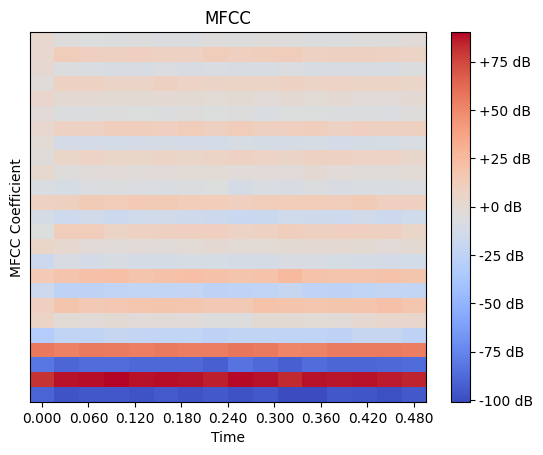

In [11]:
plot_mfcc(readTXTFile(dataset[0][0]))

In [12]:
# Split the dataset into training and testing sets.
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# Split the training set into training and validation sets.
train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)

# Store lengths of the sets.
train_len = len(train_set)
val_len = len(val_set)
test_len = len(test_set)

print(f"Training set length: {train_len}")
print(f"Validation set length: {val_len}")
print(f"Testing set length: {test_len}")

Training set length: 17119
Validation set length: 4280
Testing set length: 5350


In [13]:
# Process TXT File
# Read and and recive NP array then convert to tensor
def processTXTFile(file_path):
    return tf.convert_to_tensor(readTXTFile(file_path), dtype=tf.float16)

In [14]:
# Define the processTXTFile_tf function
def processTXTFile_tf(file_path):
    file_path = file_path.numpy().decode('utf-8')
    data = np.concatenate(processTXTFile(file_path), axis=0)
    tensor = tf.convert_to_tensor(data, dtype=tf.float16)
    tensor = tf.reshape(tensor, (25, 16, 1))  # Ensure the shape matches input_shape
    return tensor

# Separate file paths and labels
train_file_paths = [item[0] for item in train_set]
train_labels = [item[1] for item in train_set]
val_file_paths = [item[0] for item in val_set]
val_labels = [item[1] for item in val_set]

# One-hot encode the labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
train_labels = to_categorical(label_encoder.transform(train_labels))
val_labels = to_categorical(label_encoder.transform(val_labels))

# Create the x_train_tf dataset
x_train_tf = tf.data.Dataset.from_tensor_slices(train_file_paths).interleave(
    lambda file: tf.data.Dataset.from_tensors(
        tf.py_function(processTXTFile_tf, [file], [tf.float16])
    ).map(lambda x: tf.reshape(x, (25, 16, 1))),  # Ensure correct shape
    num_parallel_calls=tf.data.AUTOTUNE
)

# Create the y_train_tf dataset
y_train_tf = tf.data.Dataset.from_tensor_slices(train_labels)

# Combine x_train_tf and y_train_tf into a single dataset
train_tf = tf.data.Dataset.zip((x_train_tf, y_train_tf)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create the x_val_tf dataset
x_val_tf = tf.data.Dataset.from_tensor_slices(val_file_paths).interleave(
    lambda file: tf.data.Dataset.from_tensors(tf.py_function(processTXTFile_tf, [file], [tf.float16])),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Create the y_val_tf dataset
y_val_tf = tf.data.Dataset.from_tensor_slices(val_labels)

# Combine x_val_tf and y_val_tf into a single dataset
val_tf = tf.data.Dataset.zip((x_val_tf, y_val_tf)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Construct Sequantial Model

...

In [15]:
# Creation of the sequential model
sequential_model = Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), activation = "relu", padding = 'same', input_shape = INPUT_SHAPE),
    Conv2D(filters = 64, kernel_size = (2,2), activation = "relu", padding = 'same'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.4),
    Conv2D(filters = 128, kernel_size = (3,3), activation = "relu", padding = 'same'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dropout(0.6),
    Dense(units = len(labels), activation = "softmax")
])


/home/william/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Print a summary of the model architecture
sequential_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 16, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 16, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 492,934 (1.88 MB)

 Trainable params: 492,934 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

# Helper Functions

...

In [17]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss']) 

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [18]:
# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, train_tf, val_tf, epochs, doPrintHistory, verbose=1):
    history = model.fit(train_tf, validation_data=val_tf, epochs=epochs, verbose=verbose, steps_per_epoch=train_len // BATCH_SIZE)
    # Print history
    if doPrintHistory: printHistory(history)

# Compile & Fit Model

...

In [19]:
# Compile the model.
sequential_model.compile(
    optimizer = "Adam",
    loss = "categorical_crossentropy",
    metrics = ['categorical_accuracy']
)

In [20]:
fitModel(sequential_model, train_tf, val_tf, 16, True)

Epoch 1/16
  1/534 ━━━━━━━━━━━━━━━━━━━━ 20:07 2s/step - categorical_accuracy: 0.3438 - loss: 8.6173

2025-03-12 14:16:51.084944: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22528000 exceeds 10% of free system memory.
2025-03-12 14:16:51.086898: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22528000 exceeds 10% of free system memory.


  2/534 ━━━━━━━━━━━━━━━━━━━━ 4:17 484ms/step - categorical_accuracy: 0.3203 - loss: 8.9829

2025-03-12 14:16:51.578290: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22528000 exceeds 10% of free system memory.
2025-03-12 14:16:51.581286: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22528000 exceeds 10% of free system memory.


  3/534 ━━━━━━━━━━━━━━━━━━━━ 4:20 491ms/step - categorical_accuracy: 0.2934 - loss: 8.8989

2025-03-12 14:16:52.074662: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22528000 exceeds 10% of free system memory.


 75/534 ━━━━━━━━━━━━━━━━━━━━ 3:42 485ms/step - categorical_accuracy: 0.2274 - loss: 3.3681

KeyboardInterrupt: 